## Графы

Некоторые данные удобно естественно хранить в виде графа:

- Cтруктура молекул
- 3D объекты (mesh)
- Cвязи: соц. сети, цитаты
...

<img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L06/out/graph_vs_image_and_sequence.png" width="900">


### Свойства графов
* Направленность
* Цикличность / ацикличность
* Деревья

### Способы хранения графа

* Матрица связанности (adjacency matrix)
* CCO формат (coordinate list )
* ...

### Пакет для работы с графовыми данными

Пакет для работы с графовыми свертками:
https://pytorch-geometric.readthedocs.io/en/latest/

In [93]:
!pip install torch_geometric

### Визуализатор для графов:

https://networkx.org/
https://networkx.org/documentation/networkx-1.10/reference/drawing.html

In [94]:
import networkx as nx
from networkx.drawing.layout import circular_layout, kamada_kawai_layout
from torch_geometric.utils import to_networkx
import matplotlib.pyplot as plt
plt.figure(figsize=(4,4))

def show_graph(graph, colors = None, embeddings = False):
  fs=14
  int2label = {}
  g = to_networkx(graph, to_undirected=False) #
  if embeddings:
    for i, e in enumerate(graph.x):
      str_emb = ["{0:0.1f}".format(p.item()) for p in e]
      int2label[i] = f"{i}: [" + ",".join(str_emb)+"]"
    g = nx.relabel_nodes(g, int2label)
    fs = 10

  plt.axis('off')
  #https://networkx.org/documentation/networkx-1.10/reference/drawing.html

  #nx.draw(g,
  #        with_labels=True,
  #        node_size=800,
  #        node_color=colors)

  nx.draw_networkx(g,
                pos= kamada_kawai_layout(g, dim=2, scale=1, center=None), #nx.spring_layout(G, seed=0),
                with_labels=True,
                node_size=800,
                node_color= colors, #data.y,
                #cmap="hsv",
                #vmin=-2,
                #vmax=3,
                #width=0.8,
                edge_color="grey",
                font_size=fs
                )

<Figure size 400x400 with 0 Axes>

Создадим простой граф для демонстрации.
Сначала создаем список вершин. Для простоты каждая вершина будет содержать одно число. Но в общем случае вершина может содержать любую информацию. Чаще в виде вектора чисел. Размер эмбеддингов у всех вершин графа должен совпадать.

In [95]:
import torch
x = torch.tensor([[0],[1],[2],[3],[4],[5]], dtype=torch.float)

Теперь создадим набор ребер соединяющих вершины. Число в первой строке это **номер** исходящей вершины, число во второй (с тем же индексом) номер исходящей.

In [96]:
edge_index = torch.tensor([[0, 1,  2, 2, 3, 4, 4],
                           [1, 2,  3, 4, 5, 2, 5]], dtype=torch.long)




В pytorch_geiometrics для работы с графами используется класс [Data](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.data.Data.html#torch_geometric.data.Data)

Можно инициализировать его списком вершин и ребер

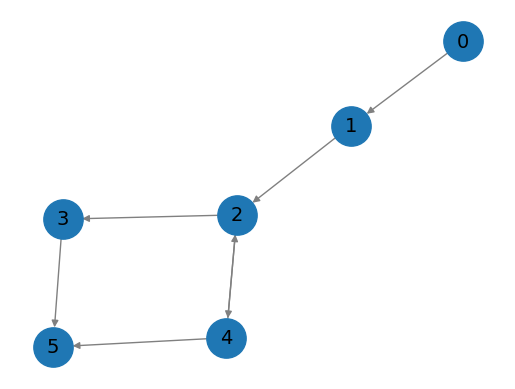

In [97]:
from torch_geometric.data import Data
data = Data(x=x, edge_index=edge_index)
data.validate(raise_on_error=True) # optional check

show_graph(data) #, ['gray','lightgreen','green','lightgreen','lightgreen', 'gray'])

# Графовые свертки

https://pytorch-geometric.readthedocs.io/en/latest/notes/cheatsheet.html

[GCNConv](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.GCNConv.html#torch_geometric.nn.conv.GCNConv)






<img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L06/out/GCN_scheme.png" width="800">

При выполнении графовой свертки описанной в статье [Semi-Supervised Classification with Graph Convolutional Networks](https://arxiv.org/abs/1609.02907) обновляется эмбеддинг каждой из вершин.

Новый эмбеддинг считаеться как взвешенная сумма скалярных произведений соседних вершин на матрицу весов.


Это напоминает свертку для изображений. Основное отличие в том что **количиство соседей** у разных вершин может отличаться и в сумме будет разное количество слагаемых. Поэтому их взвесить (множители $d_i$ на картинке.). Если все $d_i = 0$ то графовая свертка вычисляется по той же формуле.


$$y_i = \sum_{i \in N}  x_i*W$$

где
$N $ множество номеров соседей $i$-той вершины,

$x_i$ - эмбеддинг $i$-той вершины,

W - матрица - весов, **одина для всех вершин**

Вот как выглядят соседи каждой вершины которые будут участвовать в свертках

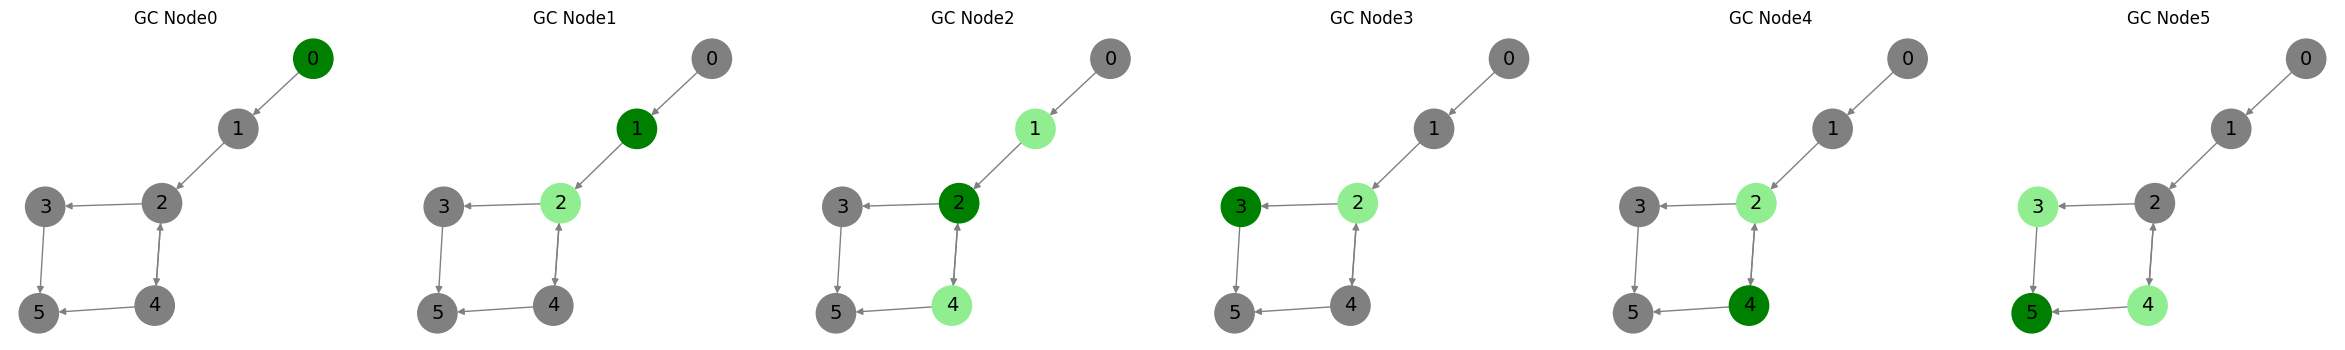

In [98]:
plt.figure(figsize=(30,4))
plt.subplot(1,6,1).set_title("GC Node0")
show_graph(data, ['green','gray','gray','gray','gray', 'gray'])
plt.subplot(1,6,2).set_title("GC Node1")
show_graph(data, ['gray','green','lightgreen','gray','gray', 'gray'])
plt.subplot(1,6,3).set_title("GC Node2")
show_graph(data, ['gray','lightgreen','green','gray','lightgreen', 'gray'])
plt.subplot(1,6,4).set_title("GC Node3")
show_graph(data, ['gray','gray','lightgreen','green','gray', 'gray'])
plt.subplot(1,6,5).set_title("GC Node4")
show_graph(data, ['gray','gray','lightgreen','gray','green', 'gray'])
plt.subplot(1,6,6).set_title("GC Node5")
show_graph(data, ['gray','gray','gray','lightgreen','lightgreen', 'green'])

В pytorch_geometrics графовая свертка реализуется классом [GCNConv](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.GCNConv.html#torch_geometric.nn.conv.GCNConv)

In [99]:
from torch_geometric.nn import GCNConv

gcn = GCNConv(in_channels = 1, out_channels = 3)
print(gcn)

GCNConv(1, 3)


`in_channels` это размерность эмбеддинга вершины гафа на входе, а `out_channels` - на выходе,

In [100]:
for name, p in gcn.named_parameters():
  print(name,p.shape)

bias torch.Size([3])
lin.weight torch.Size([3, 1])


Фактически `out_channels` это количество столбцов в матрице W

### Посмотрим как работает слой

Поскольку нам нужны эмбеддинги,
заменим значения x которые были просто равны номеру вершины на one_hot вектора

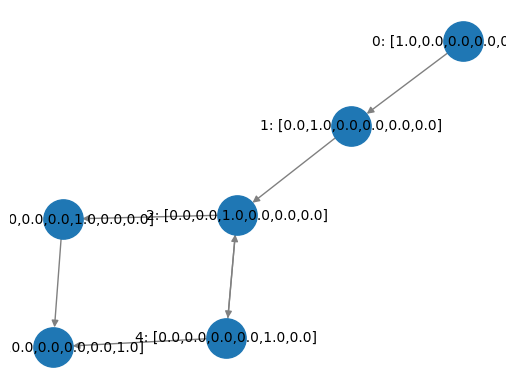

In [101]:
from torch.nn.functional import one_hot

embeddings =  one_hot(x.flatten().long()).float()
data = Data(x=embeddings, edge_index=edge_index)
data.validate(raise_on_error=True)

show_graph(data, embeddings = True)

In [102]:
print(embeddings)

tensor([[1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 1.]])


Создадим графовую свертку с одним нейроном, средствами pytorch_geometrics.
Для начала отключим все дополнительные опции и инициализируем веса единицами, что бы было проще понять как она работает.

In [103]:
gcn = GCNConv(len(x), 1, add_self_loops = False,  bias = False, normalize =False)
gcn.lin.weight.data = torch.ones((1,len(x)))
print(gcn, " weights ",gcn.lin.weight)

GCNConv(6, 1)  weights  Parameter containing:
tensor([[1., 1., 1., 1., 1., 1.]], requires_grad=True)


In [104]:
out = gcn(embeddings, edge_index)
print(out) # Embedding (dim=1) for every node from 0 ... 5

tensor([[0.],
        [1.],
        [2.],
        [1.],
        [1.],
        [2.]], grad_fn=<ScatterAddBackward0>)


Эта операция соответствует перемножению эмбеддингов вершин на веса  и сумму по всем соседям:
$$ y_i = \sum_{j \in N_i} \bar x_j \cdot \bar w$$

$N_i$ - это множество соседей $i$-й вершины, соседи - это  вершины **из которых есть путь в текущую**.



Проделаем ее без специальных классов. Эмбеддинг каждой вершины умножаеться на одну и ту же матрицу весов:

In [105]:
y = embeddings @ gcn.lin.weight.data.T
print(y)

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]])


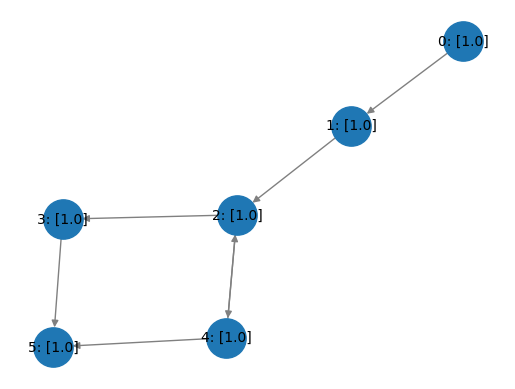

In [106]:
show_graph(Data(x = y, edge_index=edge_index), embeddings =True)

 полученных после перемножения результы суммируются для соседей каждой вершины.

В torch geometrics эта операция реализуется пакетом [torch_scatter](https://pytorch-scatter.readthedocs.io/en/latest/functions/scatter.html)


<img src="https://raw.githubusercontent.com/rusty1s/pytorch_scatter/master/docs/source/_figures/add.svg?sanitize=true" width="400">


In [107]:
oc = torch.zeros_like(y) # out custom

oc[0] = 0 # no nighbors
oc[1] = y[0] # one neighbor (#0)
oc[2] = y[1]+y[4]
oc[3] = y[2]
oc[4] = y[2]
oc[5] = y[3] + y[4]

print(oc)

assert torch.allclose(out,oc)

tensor([[0.],
        [1.],
        [2.],
        [1.],
        [1.],
        [2.]])


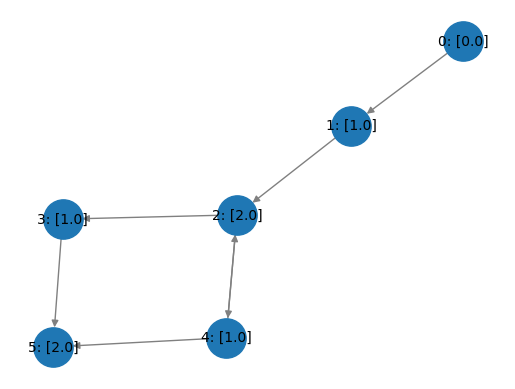

In [108]:
show_graph(Data(x = oc, edge_index=edge_index), embeddings =True)

**Улучшения**

1. Логично добавлять к сумме эмбеддинг самой вершины.
Для этого нужно либо в edge_index добавить к каждой вершине путь в саму себя, либо установить параметр конструктора GCNConv `add_self_loops = False` теперь
$x_i \in N_i$

2. Число соседей у разных вершин может сильно отличаться и результат графовой свертки  для вершины  с одним соседом, по абсолютному значению будет сильно меньше чем для вершины у которой 200 соседей. Поэтому логично нормировать выходы на количество слагаемых (число соседей вершины). Количество соседей вершины обозначим как : $deg(i) = d_i$, тогда:



$$ y_i = \frac{1}{d_i} \sum_{j \in N_i} \bar x_j \cdot \bar w  \quad (2)$$



3. Авторы статьи предложили так же учитывать количество соседей соседа. Признаки от узлов с многочисленными соседями будут распространяются легче, чем от изолированных узлов ([2017. Thomas N. Kipf](https://arxiv.org/abs/1609.02907)). Чтобы компенсировать этот эффект, они можно присваивать большие веса признакам из узлов с меньшим числом соседей.

$$ y_i =   \frac{1}{ \sqrt{d_i}} \sum_{j \in N_i} \frac {\bar x_j \cdot \bar w} {\sqrt{d_j}} = \sum_{j \in N_i} \frac  {\bar x_j \cdot \bar w} {\sqrt {d_i d_j}  } \quad(3)$$

  Что бы порядк значений сохранялся добавили корень. Теперь при $d_i == d_j$ значения $(2)$ и $(3)$ будут равны.

  4. У ребер могут быть собственные веса, задающие силу связи между вершинами. Их можно добавить при прямом проходе используя параметр `edge_weight` метода `GCNConv.forward`. По умолчанию равны 1, обозначим из как $e_{j,i}$ .
  
  Ослабление или усиление связи между вершинами означает изменение степени соседства. Поэтому $d_i = 1+\sum_{j \in N_i} e_{j,i} $ и общая формула примет вид:

  $$ y_i =   \sum_{j \in N_i} \frac  { e_{j,i} \bar x_j \cdot \bar w} {\sqrt {d_i d_j}  } \quad(4)$$




Что бы включить в сумму эмбеддинг самой вершины надо передать в конструктор  GCNConv параметр `add_self_loops = True` , а что бы  добавить нормировки на количество соседей  надо использовать установить `normalize =True`


\* *Без установки `normalized=True` установка `add_self_loops = True` работает некорректно*

In [109]:
gcn = GCNConv(len(x), 1, add_self_loops = True,  bias = False, normalize =True)
gcn.lin.weight.data = torch.ones((1,len(x)))
out = gcn(embeddings, edge_index)
print(out)

tensor([[1.0000],
        [1.2071],
        [1.1498],
        [0.9082],
        [0.9082],
        [1.1498]], grad_fn=<ScatterAddBackward0>)


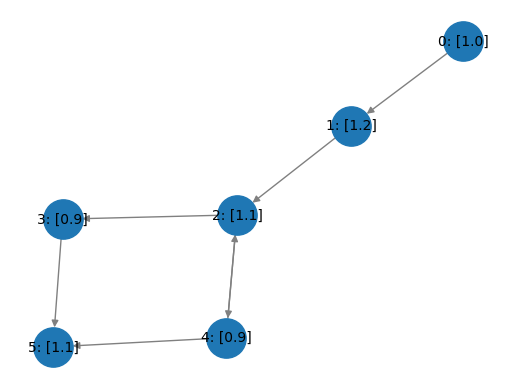

In [110]:
show_graph(Data(x = out, edge_index=edge_index), embeddings =True)

В коде это могло бы выглядеть примерно так

In [111]:
from math import sqrt

def get_neighbors(n):
  # find all neighbors of node n
  neighbors = [n] # first put to neighbors list index of node itself
  for i, node_num in enumerate(edge_index[1]):
    if node_num == n:
      neighbors.append(edge_index[0][i].item())
  return neighbors


out_norm = torch.zeros_like(out) # final summ
for i , e in enumerate(y):
  neighbors = get_neighbors(i)
  deg_i = len(neighbors) # neighbors count of node i
  for node_num in neighbors:
    deg_j = len(get_neighbors(node_num)) # neighbors count of j-th neighbor of node i
    out_norm[i] += y[node_num] / ( sqrt(deg_i)*sqrt(deg_j)) # Implementation of  equation (3)
print(out_norm)
assert torch.allclose(out,out_norm) # check that results of CGNConv the same

tensor([[1.0000],
        [1.2071],
        [1.1498],
        [0.9082],
        [0.9082],
        [1.1498]])


Добавление весов к ребрам

In [112]:
print(edge_index)

tensor([[0, 1, 2, 2, 3, 4, 4],
        [1, 2, 3, 4, 5, 2, 5]])


['1.00', '1.21', '1.15', '0.91', '0.91', '3.21']


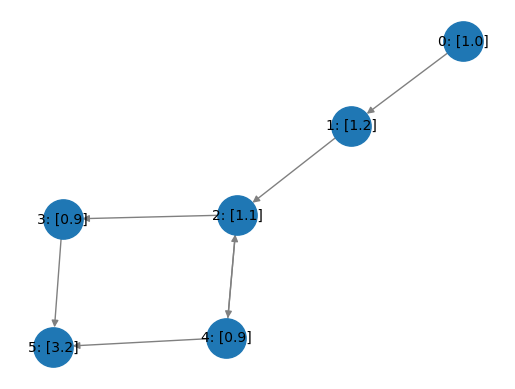

In [113]:
edge_weight = torch.Tensor([1,1,1,1,1,1,20]) # increase 4->5 edge weight

out = gcn(embeddings, edge_index, edge_weight )
#print(out.flatten().tolist())
print(["{0:0.2f}".format(i.item()) for i in out])
show_graph(Data(x = out, edge_index=edge_index), embeddings =True)

Если мы добавим в слой больше нейронов то эмбеддинги на выходе будут иметь соответствующую размерность размерность

In [114]:
gcn = GCNConv(len(x), 8, add_self_loops = True,  bias = False, normalize =True)
out = gcn(embeddings, edge_index)

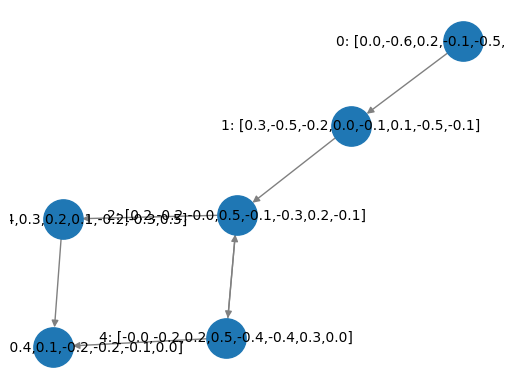

In [115]:
show_graph(Data(x = out, edge_index=edge_index), embeddings =True)

Это имеет смысл так как эмбеддинг должен вобрать в себя информацию о соседних вершинах и что бы закодировать ее требуется место. А если мы объединим несколько слоев вместе то можем добиться того что каждый эмбеддинг сможет содержать информацию о всех доступных вершинах.

In [116]:
from torch.nn import Linear
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.gcn1 = GCNConv(6, 8)
        self.gcn2 = GCNConv(8, 16)

    def forward(self, x, edge_index, batch_index = None):
        x = self.gcn1(x,edge_index).relu()
        return self.gcn2(x,edge_index)



In [117]:
model = GCN()
print(model)

GCN(
  (gcn1): GCNConv(6, 8)
  (gcn2): GCNConv(8, 16)
)


In [118]:
out = model(embeddings, edge_index)
print(out.shape)
#show_graph(Data(x = out, edge_index=edge_index), embeddings =True)

torch.Size([6, 16])


С каждым сдлоем количество соседей которое участвует в получении эмбеддинга вершины будет расти. Можно сравнить это с увеличением рецептивного поля нейрона в обчной сверточной сети. Вот пример того как будет расти рецептивное поле 3-й вершины с увеличенем числа слоев.

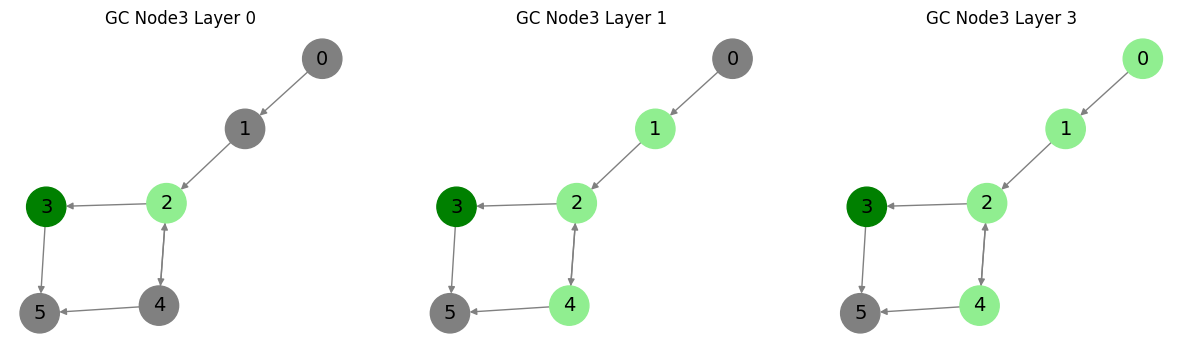

In [119]:
plt.figure(figsize=(15,4))
plt.subplot(1,3,1).set_title("GC Node3 Layer 0")
show_graph(data, ['gray','gray','lightgreen','green','gray', 'gray'])
plt.subplot(1,3,2).set_title("GC Node3 Layer 1")
show_graph(data, ['gray','lightgreen','lightgreen','green','lightgreen', 'gray'])
plt.subplot(1,3,3).set_title("GC Node3 Layer 3")
show_graph(data, ['lightgreen','lightgreen','lightgreen','green','lightgreen', 'gray'])


На выходе CGNConv слоя мы получаем граф с новыми эмбеддингами его можно использовать для решения ряда задачь:


* Можно предсказывать класс для каждой из вершин
* Можно кластеризовать вершины
* Можно классифицировать граф целиком, для этого аггрегируют эмбеддинги всех вершин и получившийся эмбеддинг подают на вохд классификатору.
* Аналогично можно предсказывать свойства всего графа решая задачу регресси


Пример классификации молекул.